# TP2: Machine learning

In [156]:
import pandas as pd
%matplotlib inline
from datetime import datetime
import scipy.spatial
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [138]:
data_training = pd.read_csv('data/properati-merge2017-2016-2015-SOLOSIX.csv')

In [61]:
def recuperar_cant_amb(x):
    "Recupera el dato amb en x (puede ser la descripcion o el titulo)"
    try:
        x = x.lower()
        if x.rfind("ambientes") != -1 or x.rfind("amb") != -1:
            pos = x.rfind("amb")
            try:
                return (float(x[pos -2])) # intento convertir lo que hay antes de la palabra
                                              #si funciona es el numero de rooms
            except ValueError:
                if "dos amb" in x:
                    return 2.0
                elif "tres amb" in x:
                    return 3.0
                elif "cuatro amb" in x:
                    return 4.0
                elif "cinco amb" in x:
                    return 5.0
                elif "seis amb" in x:
                    return 6.0
                return 0
    except AttributeError:
        return None

In [62]:
def buscar_servicios_en_descripcion(descripcion):
    """Devuelve un diccionario con 1 o 0 segun cuente con el servicio o no.
    Los servicios que consideraremos son cochera,pileta, vigilancia y gimnasio"""
    dic = {"cochera":0,"pileta":0,"vigilancia":0,"gimnasio":0,"patio":0,"terraza":0,"parrilla":0,"lavadero":0}
    descripcion = str(descripcion)
    descripcion = str.lower(descripcion)
    if "cochera" in descripcion or "garage" in descripcion:
        dic["cochera"] = 1
    elif "pileta" in descripcion or "piscina" in descripcion:
        dic["pileta"] = 1
    elif "vigilancia" in descripcion:
        dic["vigilancia"] = 1
    elif "gimnasio" in descripcion:
        dic["gimnasio"] = 1
    elif "patio" in descripcion:
        dic["patio"] = 1
    elif "terraza" in descripcion:
        dic["terraza"] = 1
    elif "parrilla" in descripcion:
        dic["parrilla"] = 1
    elif "lavadero" in descripcion:
        dic["lavadero"] = 1
    return dic

In [111]:
def contar_ambientes(x):
    "Define la cantidad de ambientes en la descripcion"
    contador = 0
    try:
        x = x.lower()
        if x.rfind("dormitorios") != -1: 
            pos = x.rfind("dormitorios")
        elif x.rfind("habitaciones") != -1:
            pos = x.rfind("habitaciones")
            try:
                contador += (float(x[pos -2])) # intento convertir lo que hay antes de la palabra
                                              #si funciona es el numero de rooms
            except ValueError:
                if ("dos dormitorios" in x) or ("dos habitaciones" in x):
                    contador += 2.0
                elif ("tres dormitorios" in x) or ("tres habitaciones" in x):
                    contador += 3.0
                elif ("cuatro dormitorios" in x) or ("cuatro habitaciones" in x):
                    contador += 4.0
                elif ("cinco dormitorios" in x) or ("cinco habitaciones" in x):
                    contador += 5.0
                elif ("seis dormitorios" in x) or ("seis habitaciones" in x):
                    contador += 6.0
        if ("living" or "comedor") in x:
            contador += 1.0
    except AttributeError:
        return None
    return contador

In [64]:
def place_name_from_parent(x): ## Segun vi el 3 item del place es generalmente el lugar
    list = x.split('|')
    if(len(list) < 5):
        return list[2]
    else:
        return list[3]

In [46]:
#Hay registros con precio en usd 0, pero en su descripcion se encuentra el precio asi que lo rescatamos
def rescatar_precio_descrip(descripcion):
    try:
        descripcion = str.lower(descripcion)
    except TypeError:
        #No tiene descripcion
        return 0
    try:
        if descripcion.rfind("usd") != -1 and descripcion.rfind("null") != -1:
            pos_usd = descripcion.rfind("usd")
            pos_null = descripcion.rfind("null")
            precio = (descripcion[pos_usd + 4 : pos_null -1]).lstrip().rstrip()
            if precio.isnumeric():
                return float(precio)
            elif descripcion.rfind('codigo: 2007-60') != -1:
                #Es un registro que no puedo recuperar genericamente
                return 35000
            else:
                #No es del formato USD precio null

                return 0
    except AttributeError:
        return 0

In [140]:
#Inicializo columnas
data_training["servicios"] = np.nan
data_training["cochera"] = int(0)
data_training["pileta"] = int(0)
data_training["vigilancia"] = int(0)
data_training["gimnasio"] = int(0)
data_training["patio"] = int(0)
data_training["terraza"] = int(0)
data_training["parrilla"] = int(0)
data_training["lavadero"] = int(0)

In [141]:
#Busco en las descripciones
data_training.loc[data_training["description"].notnull(),"servicios"] = data_training[data_training["description"].notnull()].description.apply(buscar_servicios_en_descripcion)

In [142]:
#Modifico los valores encontrados en la tabla
data_training.loc[:,"cochera"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["cochera"],axis = 1)
data_training.loc[:,"pileta"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["pileta"],axis=1)
data_training.loc[:,"vigilancia"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["vigilancia"],axis=1)
data_training.loc[:,"gimnasio"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["gimnasio"],axis=1)
data_training.loc[:,"patio"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["patio"],axis = 1)
data_training.loc[:,"terraza"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["terraza"],axis=1)
data_training.loc[:,"parrilla"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["parrilla"],axis=1)
data_training.loc[:,"lavadero"] = data_training[data_training["servicios"].notnull()].apply(lambda x: x.servicios["lavadero"],axis=1)

In [143]:
#Hay 12 campos que no se porque no se rellenan con 0
data_training.cochera.fillna(0,inplace=True)
data_training.pileta.fillna(0,inplace=True)
data_training.vigilancia.fillna(0,inplace=True)
data_training.gimnasio.fillna(0,inplace=True)
data_training.patio.fillna(0,inplace=True)
data_training.terraza.fillna(0,inplace=True)
data_training.parrilla.fillna(0,inplace=True)
data_training.lavadero.fillna(0,inplace=True)

In [144]:
#Elimino la columna servicios que ya no me sirve
data_training.drop("servicios",1,inplace=True)
data_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264021 entries, 0 to 264020
Data columns (total 31 columns):
id                            264021 non-null object
created_on                    264021 non-null object
property_type                 264021 non-null object
place_name                    263974 non-null object
place_with_parent_names       264021 non-null object
state_name                    264021 non-null object
geonames_id                   211642 non-null float64
lat-lon                       188028 non-null object
lat                           188028 non-null float64
lon                           188028 non-null float64
price                         246208 non-null float64
currency                      238346 non-null object
price_aprox_local_currency    246208 non-null float64
price_aprox_usd               246208 non-null float64
surface_total_in_m2           189637 non-null float64
surface_covered_in_m2         231150 non-null float64
price_usd_per_m2              160

In [145]:
data_training.loc[data_training['price_aprox_usd'] == 0,'price_aprox_usd'] = data_training.loc[data_training['price_aprox_usd'] == 0].description.apply(rescatar_precio_descrip)

In [146]:
data_training = data_training[data_training['state_name'].str.contains('G.B.A') | data_training['state_name'].str.contains('Capital Federal')]
##El tp dice solo gba y caba

data_training.dropna(axis=0,subset=['price_aprox_usd'],inplace=True) ## drop de los datos sin precio
data_training = data_training.loc[data_training['price_aprox_usd'] > 0,:]

#Recuperamos el dato rooms en el titulo y la descripcion
data_training.loc[data_training.rooms.isnull(),'rooms'] = data_training.loc[data_training.rooms.isnull()].description.apply(recuperar_cant_amb)
data_training.loc[data_training.rooms.isnull(),'rooms'] = data_training.loc[data_training.rooms.isnull()].title.apply(recuperar_cant_amb)
#Recuperamos el dato rooms en la descripcion contando ambientes (living y dormitorios)
data_training.loc[data_training.rooms.isnull(),'rooms'] = data_training.loc[data_training.rooms.isnull()].description.apply(contar_ambientes)
data_training.loc[data_training.rooms == 0,'rooms'] = data_training.loc[data_training.rooms == 0].description.apply(contar_ambientes)


data_training.loc[:,'place_name'] = data_training.place_with_parent_names.apply(place_name_from_parent)
## esto quita muchos problemas de place name como nombres de country o palermo soho

In [147]:
data_training = data_training.dropna(axis = 0, subset = ['price_aprox_usd','surface_total_in_m2'],how ='any')
data_training['year'] = 0
data_training['month'] = 0
data_training.loc[:,'created_on'] = data_training.created_on.apply(pd.to_datetime)

In [148]:
data_training.loc[:,'year'] = data_training.created_on.apply(lambda x: x.year)
data_training.loc[:,'month'] = data_training.created_on.apply(lambda x: x.month)
data_training.drop('created_on',1,inplace=True)

In [149]:
#Hay 2 registro con rooms nan irrecuperables
data_training.drop(132299,inplace=True)
data_training.drop(95386,inplace=True)

In [150]:
#NO considerare lat lon porque reduce mucho los registros
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171112 entries, 0 to 264017
Data columns (total 32 columns):
id                            171112 non-null object
property_type                 171112 non-null object
place_name                    171112 non-null object
place_with_parent_names       171112 non-null object
state_name                    171112 non-null object
geonames_id                   136701 non-null float64
lat-lon                       121217 non-null object
lat                           121217 non-null float64
lon                           121217 non-null float64
price                         171112 non-null float64
currency                      171064 non-null object
price_aprox_local_currency    171112 non-null float64
price_aprox_usd               171112 non-null float64
surface_total_in_m2           171112 non-null float64
surface_covered_in_m2         163024 non-null float64
price_usd_per_m2              160036 non-null float64
price_per_m2                  15

In [151]:
#Recuperamos registros a los que no se les calculo el precio por m2 en dolares
data_training.loc[data_training['price_usd_per_m2'].isnull(),'price_usd_per_m2'] = data_training.surface_total_in_m2 / data_training.price_aprox_usd
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171112 entries, 0 to 264017
Data columns (total 32 columns):
id                            171112 non-null object
property_type                 171112 non-null object
place_name                    171112 non-null object
place_with_parent_names       171112 non-null object
state_name                    171112 non-null object
geonames_id                   136701 non-null float64
lat-lon                       121217 non-null object
lat                           121217 non-null float64
lon                           121217 non-null float64
price                         171112 non-null float64
currency                      171064 non-null object
price_aprox_local_currency    171112 non-null float64
price_aprox_usd               171112 non-null float64
surface_total_in_m2           171112 non-null float64
surface_covered_in_m2         163024 non-null float64
price_usd_per_m2              171112 non-null float64
price_per_m2                  15

In [152]:
from sklearn.preprocessing import LabelEncoder

#Vamos a codificar cada columna que sea de strings
lb_make1 = LabelEncoder()
data_training["property_type_code"] = lb_make1.fit_transform(data_training["property_type"])

lb_make2 = LabelEncoder()
data_training["place_name_code"] = lb_make2.fit_transform(data_training["place_name"])

lb_make3 = LabelEncoder()
data_training["place_with_parent_names_code"] = lb_make3.fit_transform(data_training["place_with_parent_names"])

lb_make4 = LabelEncoder()
data_training["state_name_code"] = lb_make4.fit_transform(data_training["state_name"])

In [161]:
data_training2 = data_training[['lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'price_usd_per_m2', 'rooms', 'year', 'month', 'property_type_code',
       'place_name_code', 'place_with_parent_names_code', 'state_name_code']]

data_training2 = data_training2.dropna(axis = 0, subset = ['lat','lon'],how ='any')

LOGR: 0.937963 (0.018299)


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.951277 (0.019488)
KNN: 0.892392 (0.015062)
CART: 1.000000 (0.000000)
NB: 0.965533 (0.020829)


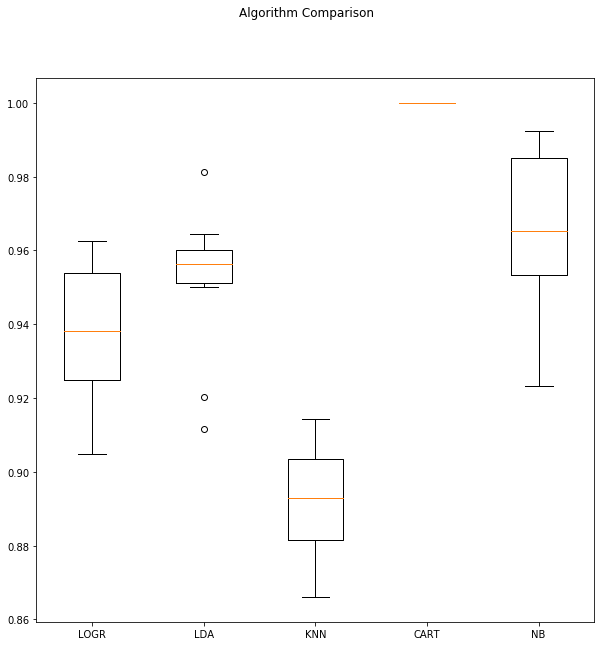

In [162]:
# Compare Algorithms

# load dataset
#url = '/home/lucio/Documentos/OrgaDeDatos/ProperatiDatosTP/data/asdasd.csv'
#names = ['created_on', 'lat','lon', 'price_aprox_usd', 'price_usd_per_m2',\
#                'property_type','rooms','surface_total_in_m2']

dataframe = data_training2
array = dataframe.values
X = array[:,0:11]
Y = array[:,11]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LOGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) # En casi 3hs nadaaa si alguno lo prueba y le anda en menos copado jaja
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [154]:
#Sin considerar latitudes
data_training3 = data_training[['price_aprox_usd', 'surface_total_in_m2',
       'price_usd_per_m2', 'rooms', 'year', 'month', 'property_type_code',
       'place_name_code', 'place_with_parent_names_code', 'state_name_code']]

LR: 0.902976 (0.066592)
LDA: 0.949963 (0.028033)
KNN: 0.901106 (0.015736)
CART: 1.000000 (0.000000)
NB: 0.963264 (0.028974)


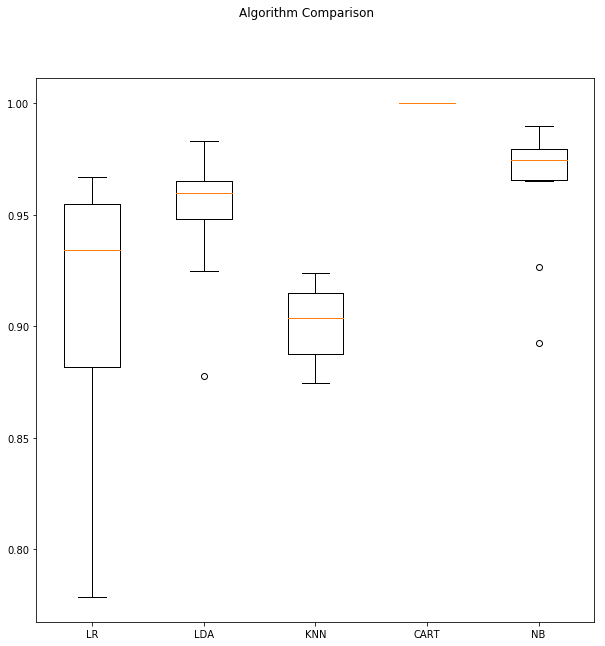

In [157]:
dataframe = data_training3
array = dataframe.values
X = array[:,0:9]
Y = array[:,9]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) # En casi 3hs nadaaa si alguno lo prueba y le anda en menos copado jaja
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()